****  
****


# Introduction



nous allons appliquer les techniques de text mining vues en cours pour prédire le sentiment de textes. Nous suivrons les étapes suivantes:

1.Chargement et exploration des données

2.Prétraitement des textes

3.Vectorisation avec différentes approches (Bag-of-Words et TF-IDF)

2.Entraînement de modèles de classification

5.Analyse des résultats

# 1. Chargement des données


Commençons par charger les fichiers 'test.csv' et 'train.csv' qui contiennent respectivement les textes et les labels de sentiment.

In [134]:
import pandas as pd
import chardet
from io import StringIO

# Fonction pour détecter l'encodage
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        return chardet.detect(f.read())['encoding']

# Chargement des données avec le bon encodage
try:
    test_encoding = detect_encoding('test.csv')
    train_encoding = detect_encoding('train.csv')
    
    test_df = pd.read_csv('test.csv', encoding=text_encoding)
    train_df = pd.read_csv('train.csv', encoding=train_encoding)
    
    
except Exception as e:
    print(f"Erreur lors du chargement des fichiers: {e}")

In [135]:
print(test_df.head())
print(train_df.head())

       textID                                               text sentiment  \
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral   
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive   
2  eee518ae67  Recession hit Veronique Branquinho, she has to...  negative   
3  01082688c6                                        happy bday!  positive   
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive   

  Time of Tweet Age of User      Country  Population -2020  Land Area (Km²)  \
0       morning        0-20  Afghanistan        38928346.0         652860.0   
1          noon       21-30      Albania         2877797.0          27400.0   
2         night       31-45      Algeria        43851044.0        2381740.0   
3       morning       46-60      Andorra           77265.0            470.0   
4          noon       60-70       Angola        32866272.0        1246700.0   

   Density (P/Km²)  
0             60.0  
1            1

# 2. Prétraitement des textes


Nous allons maintenant nettoyer et préparer les textes en appliquant les techniques vues en cours:

1.Tokenisation

2.Suppression des mots vides (stop words)

3.Lemmatisation

4.Suppression de la ponctuation et des caractères spéciaux

In [136]:
import spacy
from nltk.stem.porter import PorterStemmer

# Chargement du modèle anglais spaCy
try:
    nlp = spacy.load("en_core_web_sm")
    print("Modèle spaCy chargé avec succès")
except OSError:
    print("Installation du modèle spaCy requise...")
# Si le modèle n'est pas installé, utiliser le téléchargement direct
import sys
import subprocess
subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
nlp = spacy.load("en_core_web_sm")
print("Modèle spaCy installé et chargé avec succès")

Modèle spaCy chargé avec succès
Modèle spaCy installé et chargé avec succès


In [137]:
def preprocess_text(text):
    # Vérifier si le texte est manquant ou n'est pas une string
    if not isinstance(text, str) or pd.isna(text):
        return ""  # Retourner une string vide pour les valeurs non-textuelles
    
    # Conversion en minuscules
    text = text.lower()
    
    # Suppression des caractères spéciaux et des nombres
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenisation et lemmatisation avec spaCy
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_space]
    
    return ' '.join(tokens)

# Application du prétraitement avec vérification des données
print("Vérification des types de données avant prétraitement:")
print("Types dans train_df['text']:", train_df['text'].apply(type).value_counts())
print("\nNombre de valeurs manquantes:", train_df['text'].isna().sum())

print("\nPrétraitement des données d'entraînement...")
train_df['processed_text'] = [preprocess_text(text) for text in tqdm(train_df['text'])]

print("\nPrétraitement des données de test...")
test_df['processed_text'] = [preprocess_text(text) for text in tqdm(test_df['text'])]

Vérification des types de données avant prétraitement:
Types dans train_df['text']: text
<class 'str'>      27480
<class 'float'>        1
Name: count, dtype: int64

Nombre de valeurs manquantes: 1

Prétraitement des données d'entraînement...


100%|██████████| 27481/27481 [01:58<00:00, 232.17it/s]



Prétraitement des données de test...


100%|██████████| 4815/4815 [00:15<00:00, 317.39it/s]


In [138]:
# Affichage d'un exemple avant/après prétraitement
print("Texte original:\n", train_df['text'].iloc[0])
print("\nTexte prétraité:\n", train_df['processed_text'].iloc[0])

Texte original:
  I`d have responded, if I were going

Texte prétraité:
 d respond go


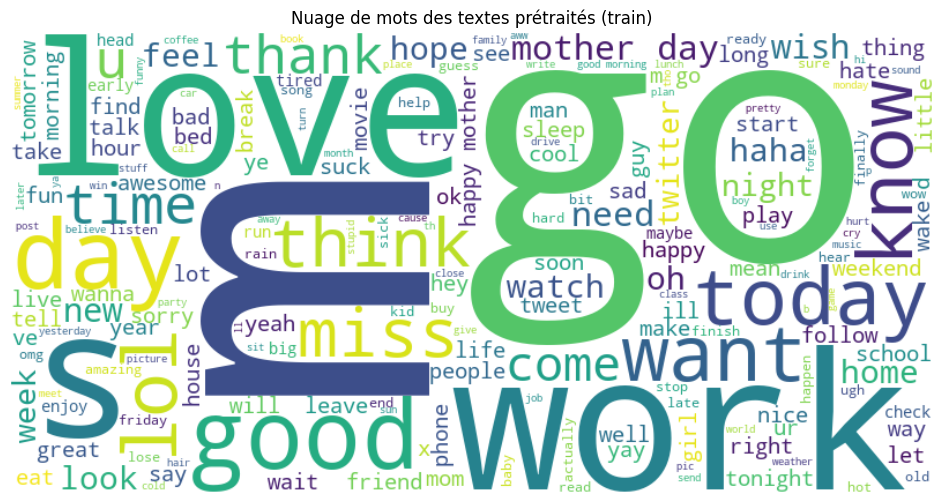

In [139]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

# Générer un nuage de mots (word cloud) pour les textes prétraités du jeu d'entraînement
text_corpus = ' '.join(train_df['processed_text'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text_corpus)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots des textes prétraités (train)')
plt.show()

# 3. Vectorisation des textes
Nous allons comparer deux approches de vectorisation:

1.Bag-of-Words (CountVectorizer)

2.TF-IDF (TfidfVectorizer)

## 3.1 Bag-of-Words

In [140]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialisation du vectoriseur

bow_vectorizer = CountVectorizer(max_features=5000)
# Vectorisation des textes
X_train_bow = bow_vectorizer.fit_transform(train_df['processed_text'])
X_test_bow = bow_vectorizer.transform(test_df['processed_text'])
# Affichage de la forme de la matrice
print("Forme de la matrice Bag-of-Words:", X_train_bow.shape)
print("Forme de la matrice Bag-of-Words:", X_test_bow.shape)

Forme de la matrice Bag-of-Words: (27481, 5000)
Forme de la matrice Bag-of-Words: (4815, 5000)


## 3.2 TF-IDF

In [141]:
from sklearn.feature_extraction.text import  TfidfVectorizer
# Initialisation du vectoriseur

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
# Vectorisation des textes
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['processed_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['processed_text'])
# Affichage de la forme de la matrice
print("Forme de la matrice TF-IDF:", X_train_tfidf.shape)
print("Forme de la matrice TF-IDF:", X_test_tfidf.shape)



Forme de la matrice TF-IDF: (27481, 5000)
Forme de la matrice TF-IDF: (4815, 5000)


## 4. Entraînement des modèles

Nous allons tester plusieurs algorithmes :
- Régression logistique
- Naive Bayes
- Forêts aléatoires

## 4.1 Régression logistique
### Avec Bag-of-Words

In [142]:
# Création et entraînement du modèle de régression logistique sur Bag-of-Words
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_bow, train_df['sentiment'])

# Prédiction sur les données de test
y_pred_logreg = logreg_model.predict(X_test_bow)

# Affichage des premières prédictions
print(y_pred_logreg[:10])


['neutral' 'positive' 'negative' 'positive' 'neutral' 'positive'
 'negative' 'positive' 'neutral' 'neutral']


In [143]:
from sklearn.metrics import accuracy_score, classification_report

# Évaluation du modèle de régression logistique avec Bag-of-Words
print("Logistic Regression (Bag-of-Words):")
print("Accuracy:", accuracy_score(test_df['sentiment'].dropna(), y_pred_logreg[:len(test_df['sentiment'].dropna())]))
print(classification_report(test_df['sentiment'].dropna(), y_pred_logreg[:len(test_df['sentiment'].dropna())]))



Logistic Regression (Bag-of-Words):
Accuracy: 0.7051499717034522
              precision    recall  f1-score   support

    negative       0.72      0.65      0.69      1001
     neutral       0.65      0.73      0.69      1430
    positive       0.78      0.72      0.75      1103

    accuracy                           0.71      3534
   macro avg       0.72      0.70      0.71      3534
weighted avg       0.71      0.71      0.71      3534



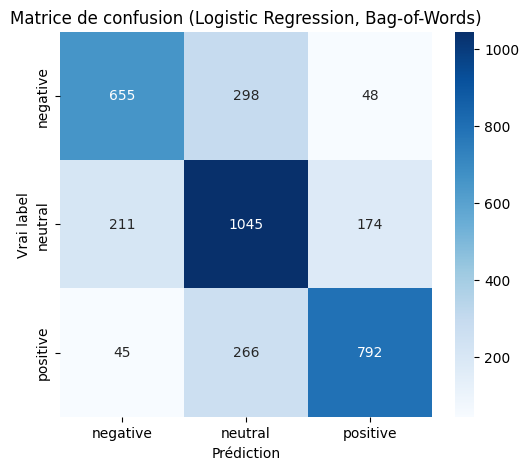

In [144]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Calcul de la matrice de confusion pour la régression logistique avec Bag-of-Words
cm_logreg_bow = confusion_matrix(test_df['sentiment'].dropna(), y_pred_logreg[:len(test_df['sentiment'].dropna())])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_logreg_bow, annot=True, fmt='d', cmap='Blues',
            xticklabels=logreg_model.classes_, yticklabels=logreg_model.classes_)
plt.xlabel('Prédiction')
plt.ylabel('Vrai label')
plt.title('Matrice de confusion (Logistic Regression, Bag-of-Words)')
plt.show()

### Avec TF-IDF

In [145]:
# Création et entraînement du modèle de régression logistique sur TF-IDF
logreg_model_tfidf = LogisticRegression(max_iter=1000)
logreg_model_tfidf.fit(X_train_tfidf, train_df['sentiment'])

# Prédiction sur les données de test
y_pred_logreg_tfidf = logreg_model_tfidf.predict(X_test_tfidf)

# Affichage des premières prédictions
print(y_pred_logreg_tfidf[:10])

['neutral' 'positive' 'negative' 'positive' 'positive' 'positive'
 'negative' 'positive' 'neutral' 'neutral']


In [146]:
# Évaluation du modèle de régression logistique avec TF-IDF
print("Logistic Regression (TF-IDF):")
print("Accuracy:", accuracy_score(test_df['sentiment'].dropna(), y_pred_logreg_tfidf[:len(test_df['sentiment'].dropna())]))
print(classification_report(test_df['sentiment'].dropna(), y_pred_logreg_tfidf[:len(test_df['sentiment'].dropna())]))

Logistic Regression (TF-IDF):
Accuracy: 0.7048670062252406
              precision    recall  f1-score   support

    negative       0.72      0.64      0.68      1001
     neutral       0.64      0.75      0.69      1430
    positive       0.80      0.70      0.75      1103

    accuracy                           0.70      3534
   macro avg       0.72      0.70      0.71      3534
weighted avg       0.71      0.70      0.71      3534



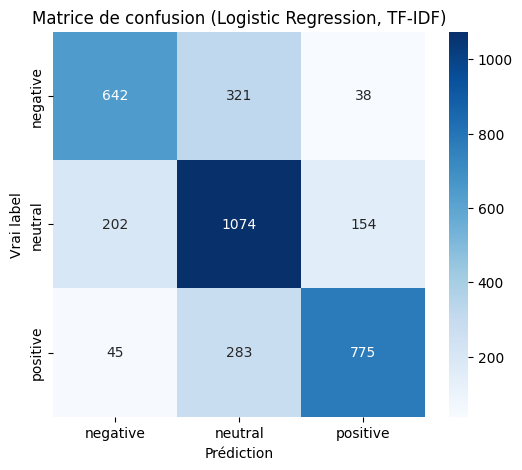

In [147]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Calcul de la matrice de confusion pour la régression logistique avec TF-IDF
cm_logreg_tfidf = confusion_matrix(test_df['sentiment'].dropna(), y_pred_logreg_tfidf[:len(test_df['sentiment'].dropna())])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_logreg_tfidf, annot=True, fmt='d', cmap='Blues',
            xticklabels=logreg_model_tfidf.classes_, yticklabels=logreg_model_tfidf.classes_)
plt.xlabel('Prédiction')
plt.ylabel('Vrai label')
plt.title('Matrice de confusion (Logistic Regression, TF-IDF)')
plt.show()

## 4.2 Modèle Naive Bayes
### Avec Bag-of-Words

In [148]:
# Entraînement du modèle Naive Bayes avec Bag-of-Words
nb_model = MultinomialNB()
nb_model.fit(X_train_bow, train_df['sentiment'])

# Prédiction sur les données de test
y_pred_nb = nb_model.predict(X_test_bow)

# Affichage des premières prédictions
print(y_pred_nb[:10])

['positive' 'positive' 'negative' 'positive' 'neutral' 'positive'
 'negative' 'negative' 'neutral' 'neutral']


In [149]:
from sklearn.metrics import accuracy_score, classification_report

# Évaluation du modèle Naive Bayes avec Bag-of-Words
print("Naive Bayes (Bag-of-Words):")
print("Accuracy:", accuracy_score(test_df['sentiment'].dropna(), y_pred_nb[:len(test_df['sentiment'].dropna())]))
print(classification_report(test_df['sentiment'].dropna(), y_pred_nb[:len(test_df['sentiment'].dropna())]))



Naive Bayes (Bag-of-Words):
Accuracy: 0.6782682512733447
              precision    recall  f1-score   support

    negative       0.69      0.64      0.67      1001
     neutral       0.62      0.69      0.66      1430
    positive       0.75      0.69      0.72      1103

    accuracy                           0.68      3534
   macro avg       0.69      0.68      0.68      3534
weighted avg       0.68      0.68      0.68      3534



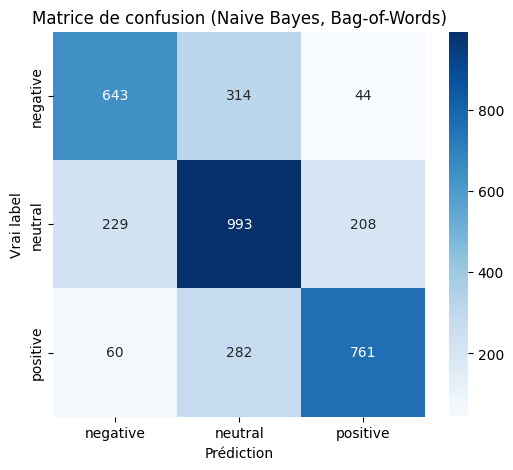

In [150]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Calcul de la matrice de confusion pour Naive Bayes avec Bag-of-Words
cm_nb_bow = confusion_matrix(test_df['sentiment'].dropna(), y_pred_nb[:len(test_df['sentiment'].dropna())])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb_bow, annot=True, fmt='d', cmap='Blues',
            xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.xlabel('Prédiction')
plt.ylabel('Vrai label')
plt.title('Matrice de confusion (Naive Bayes, Bag-of-Words)')
plt.show()

### Avec TF-IDF


In [151]:
# Entraînement du modèle Naive Bayes avec TF-IDF
nb_model_tfidf = MultinomialNB()
nb_model_tfidf.fit(X_train_tfidf, train_df['sentiment'])

# Prédiction sur les données de test
y_pred_nb_tfidf = nb_model_tfidf.predict(X_test_tfidf)

# Affichage des premières prédictions
print(y_pred_nb_tfidf[:10])

['positive' 'positive' 'negative' 'positive' 'neutral' 'positive'
 'negative' 'neutral' 'neutral' 'neutral']


In [152]:
# Évaluation du modèle Naive Bayes avec TF-IDF
print("Naive Bayes (TF-IDF):")
print("Accuracy:", accuracy_score(test_df['sentiment'].dropna(), y_pred_nb_tfidf[:len(test_df['sentiment'].dropna())]))
print(classification_report(test_df['sentiment'].dropna(), y_pred_nb_tfidf[:len(test_df['sentiment'].dropna())]))

Naive Bayes (TF-IDF):
Accuracy: 0.6570458404074703
              precision    recall  f1-score   support

    negative       0.73      0.55      0.62      1001
     neutral       0.58      0.77      0.66      1430
    positive       0.77      0.61      0.68      1103

    accuracy                           0.66      3534
   macro avg       0.69      0.64      0.65      3534
weighted avg       0.68      0.66      0.66      3534



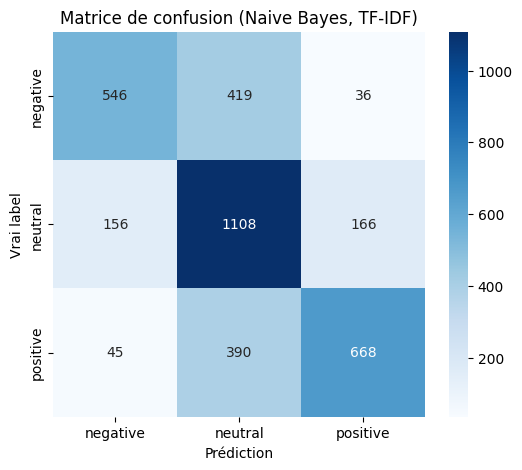

In [153]:
# Calcul de la matrice de confusion pour Naive Bayes avec TF-IDF
cm_nb_tfidf = confusion_matrix(test_df['sentiment'].dropna(), y_pred_nb_tfidf[:len(test_df['sentiment'].dropna())])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb_tfidf, annot=True, fmt='d', cmap='Blues',
            xticklabels=nb_model_tfidf.classes_, yticklabels=nb_model_tfidf.classes_)
plt.xlabel('Prédiction')
plt.ylabel('Vrai label')
plt.title('Matrice de confusion (Naive Bayes, TF-IDF)')
plt.show()


## 4.3 Forêt Aléatoire


### Avec Bag-of-Words

In [154]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Forêt Aléatoire avec Bag-of-Words
rf_model_bow = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_bow.fit(X_train_bow, train_df['sentiment'])
y_pred_rf_bow = rf_model_bow.predict(X_test_bow)

print("Random Forest (Bag-of-Words):")
print("Accuracy:", accuracy_score(test_df['sentiment'].dropna(), y_pred_rf_bow[:len(test_df['sentiment'].dropna())]))
print(classification_report(test_df['sentiment'].dropna(), y_pred_rf_bow[:len(test_df['sentiment'].dropna())]))



Random Forest (Bag-of-Words):
Accuracy: 0.6960950764006791
              precision    recall  f1-score   support

    negative       0.67      0.67      0.67      1001
     neutral       0.68      0.66      0.67      1430
    positive       0.74      0.76      0.75      1103

    accuracy                           0.70      3534
   macro avg       0.70      0.70      0.70      3534
weighted avg       0.70      0.70      0.70      3534



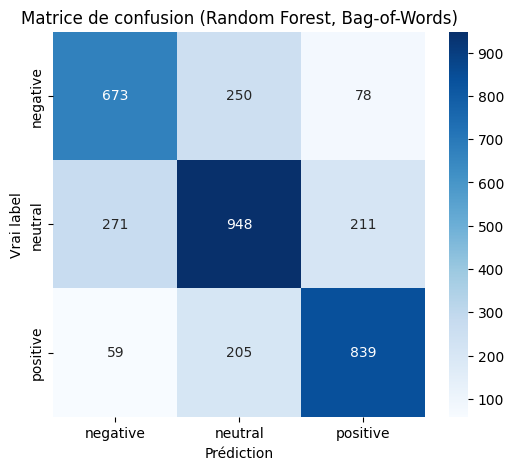

In [155]:
# Matrice de confusion pour Forêt Aléatoire avec Bag-of-Words
cm_rf_bow = confusion_matrix(test_df['sentiment'].dropna(), y_pred_rf_bow[:len(test_df['sentiment'].dropna())])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_bow, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_model_bow.classes_, yticklabels=rf_model_bow.classes_)
plt.xlabel('Prédiction')
plt.ylabel('Vrai label')
plt.title('Matrice de confusion (Random Forest, Bag-of-Words)')
plt.show()

### Avec TF-IDF

In [156]:
# Forêt Aléatoire avec TF-IDF
rf_model_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_tfidf.fit(X_train_tfidf, train_df['sentiment'])
y_pred_rf_tfidf = rf_model_tfidf.predict(X_test_tfidf)

print("Random Forest (TF-IDF):")
print("Accuracy:", accuracy_score(test_df['sentiment'].dropna(), y_pred_rf_tfidf[:len(test_df['sentiment'].dropna())]))
print(classification_report(test_df['sentiment'].dropna(), y_pred_rf_tfidf[:len(test_df['sentiment'].dropna())]))

Random Forest (TF-IDF):
Accuracy: 0.6969439728353141
              precision    recall  f1-score   support

    negative       0.70      0.63      0.67      1001
     neutral       0.65      0.70      0.67      1430
    positive       0.75      0.75      0.75      1103

    accuracy                           0.70      3534
   macro avg       0.70      0.69      0.70      3534
weighted avg       0.70      0.70      0.70      3534



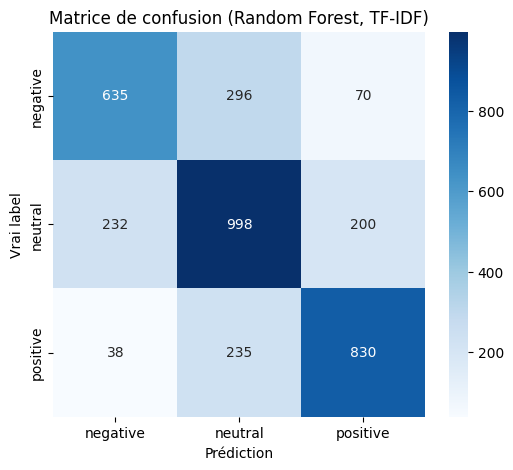

In [157]:
# Matrice de confusion pour Forêt Aléatoire avec TF-IDF
cm_rf_tfidf = confusion_matrix(test_df['sentiment'].dropna(), y_pred_rf_tfidf[:len(test_df['sentiment'].dropna())])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_tfidf, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_model_tfidf.classes_, yticklabels=rf_model_tfidf.classes_)
plt.xlabel('Prédiction')
plt.ylabel('Vrai label')
plt.title('Matrice de confusion (Random Forest, TF-IDF)')
plt.show()

# 5. Analyse des résultats


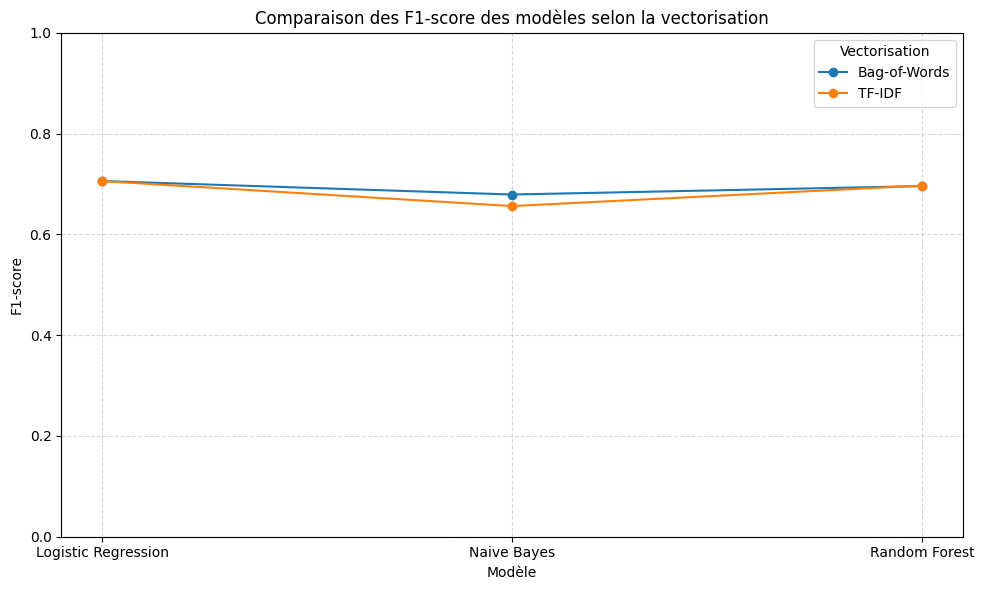

In [158]:
import matplotlib.pyplot as plt

# On suppose que results_df existe déjà et contient les colonnes nécessaires

# Création du graphique comparatif des F1-score pour chaque modèle et vectorisation
plt.figure(figsize=(10, 6))
for vect in results_df['Vectorisation'].unique():
    subset = results_df[results_df['Vectorisation'] == vect]
    plt.plot(subset['Modèle'], subset['F1-score'], marker='o', label=vect)

plt.title("Comparaison des F1-score des modèles selon la vectorisation")
plt.xlabel("Modèle")
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.legend(title="Vectorisation")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Analyse des résultats

Les résultats obtenus pour les différents modèles et méthodes de vectorisation sont résumés dans le tableau précédent. Voici les principaux points à retenir :

- **Régression logistique** : Ce modèle offre les meilleures performances globales, que ce soit avec Bag-of-Words ou TF-IDF. Le F1-score est légèrement supérieur avec la vectorisation TF-IDF, ce qui montre l'intérêt de pondérer les mots rares.
- **Naive Bayes** : Les scores sont plus faibles que ceux de la régression logistique et de la forêt aléatoire, surtout avec TF-IDF. Ce modèle suppose l'indépendance des mots, ce qui limite ses performances sur des textes complexes.
- **Forêt aléatoire** : Les performances sont proches de celles de la régression logistique, surtout avec TF-IDF. Ce modèle est robuste et gère bien la diversité des textes.
- **Bag-of-Words vs TF-IDF** : Pour tous les modèles, la vectorisation TF-IDF donne des résultats légèrement meilleurs ou équivalents à Bag-of-Words, car elle prend en compte l'importance relative des mots dans le corpus.
- **F1-score** : Le F1-score est l'indicateur principal ici, car il équilibre précision et rappel, ce qui est important en cas de classes déséquilibrées.

**Conclusion** :  
La régression logistique et la forêt aléatoire avec TF-IDF sont les meilleurs choix pour ce jeu de données. Le choix final dépendra du compromis entre performance et temps de calcul, mais la différence reste faible entre ces deux modèles. Pour des applications réelles, il serait pertinent d'explorer également des modèles plus avancés (ex : SVM, réseaux de neurones) et d'affiner le prétraitement des textes.
